<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/SGLD_DP_PrivacyEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/JavierAntoran/Bayesian-Neural-Networks.git
!git clone https://github.com/knamdar/data.git

Cloning into 'Bayesian-Neural-Networks'...
remote: Enumerating objects: 369, done.
remote: Total 369 (delta 0), reused 0 (delta 0), pack-reused 369
Receiving objects: 100% (369/369), 15.98 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Cloning into 'data'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [ ]:
!pip install opacus==0.13

     |████████████████████████████████| 102kB 4.3MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


#### Base imports

In [ ]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.optim import Optimizer
from opacus import PrivacyEngine

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import collections
import h5py, sys
import gzip
import os
import math
import pickle

## Some utility functions

In [ ]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)


suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()



## Base network wrapper

In [ ]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

## Bayesian Linear 2 Layers MNIST

In [ ]:
class Linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear_2L, self).__init__()
        
        n_hid = 1200
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x):

        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x = self.fc1(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc3(x)

        return y
    
    
        

## CNN model for DP DNN MNIST (state of art) 

In [ ]:
class SampleConvNet_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # x of shape [B, 1, 28, 28]
        x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.relu(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

    def name(self):
        return "SampleConvNet"

# Custom SGLD optimiser

In [ ]:
from torch.optim.optimizer import Optimizer, required
class SGLD(Optimizer):
    """
    SGLD optimiser based on pytorch's SGD. 
    Note that the weight decay is specified in terms of the gaussian prior sigma
    """

    def __init__(self, params, lr=required, norm_sigma=0,laplace_b=0, addnoise=True):
        
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        
        defaults = dict(lr=lr, norm_sigma=norm_sigma, laplace_b=laplace_b,addnoise=addnoise)
        
        super(SGLD, self).__init__(params, defaults)

    def step(self,closure=0):
        """
        Performs a single optimization step.
        """
        loss = None
        
        for group in self.param_groups:

            norm_sigma = group['norm_sigma']
            laplace_b=group['laplace_b']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if norm_sigma != 0:
                    p.data.add_(-group['lr']/norm_sigma**2, p.data)
                if laplace_b != 0:
                    p.data.add_(-group['lr']/laplace_b,torch.sign(p.data))

                if group['addnoise']:  
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.data.add_(-group['lr'], d_p  + langevin_noise)
                else:
                    p.data.add_(-group['lr'], d_p )

        return loss

# pSGLD optimiser


In [ ]:
class pSGLD(Optimizer):
    """
    RMSprop preconditioned SGLD using pytorch rmsprop implementation.
    """

    def __init__(self, params, lr=required, norm_sigma=0,laplace_b=0, alpha=0.99, eps=1e-8, centered=False, addnoise=True):
        
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr, norm_sigma=norm_sigma,laplace_b=laplace_b, alpha=alpha, eps=eps, centered=centered, addnoise=addnoise)
        super(pSGLD, self).__init__(params, defaults)
        
    def __setstate__(self, state):
        super(pSGLD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('centered', False)

    def step(self,closure=0):
        """
        Performs a single optimization step.
        """
        loss = None

        for group in self.param_groups:
            norm_sigma = group['norm_sigma']
            laplace_b=group['laplace_b']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data



                state = self.state[p]
                
                if len(state) == 0:
                    state['step'] = 0
                    state['square_avg'] = torch.zeros_like(p.data)
                    if group['centered']:
                        state['grad_avg'] = torch.zeros_like(p.data)
                        
                square_avg = state['square_avg']
                alpha = group['alpha']
                state['step'] += 1
                
                if norm_sigma != 0:
                    p.data.add_(-group['lr']/norm_sigma**2, p.data)
                if laplace_b != 0:
                    p.data.add_(-group['lr']/laplace_b,torch.sign(p.data))

                # sqavg x alpha + (1-alph) sqavg *(elemwise) sqavg
                square_avg.mul_(alpha).addcmul_(1-alpha, d_p, d_p)
                
                if group['centered']:
                    grad_avg = state['grad_avg']
                    grad_avg.mul_(alpha).add_(1-alpha, d_p)
                    avg = square_avg.cmul(-1, grad_avg, grad_avg).sqrt().add_(group['eps'])
                else:
                    avg = square_avg.sqrt().add_(group['eps'])
                    
#                 print(avg.shape)
                if group['addnoise']:
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.data.add_(-group['lr'],
                                0.5*d_p.div_(avg) + langevin_noise/torch.sqrt(avg))
                    
                else:
                    p.data.addcdiv_(-group['lr'], 0.5*d_p, avg)


        return loss

# Network wrapper 

In [ ]:
class Net_langevin(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, cuda=True, classes=10, N_train=60000, norm_sigma=0,laplace_b=0,DP_or_Not=True,which_net=None,pSGLD_or_Not=False):
        super(Net_langevin, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.norm_sigma = norm_sigma
        self.laplace_b=laplace_b
        self.classes = classes
        self.N_train = N_train

        self.which_net=which_net
        self.create_net()
        self.pSGLD_or_Not=pSGLD_or_Not
        self.create_opt()
        self.epoch = 0
        self.weight_set_samples = []

        self.test=False
        self.DP_or_Not=DP_or_Not

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = self.which_net
        if self.cuda:
            self.model.cuda()
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))
    
    def create_opt(self):
        if self.pSGLD_or_Not:
            self.optimizer = pSGLD(params=self.model.parameters(), lr=self.lr, norm_sigma=self.norm_sigma,laplace_b=self.laplace_b, addnoise=1-DP_or_Not)
        else:
            self.optimizer = SGLD(params=self.model.parameters(), lr=self.lr, norm_sigma=self.norm_sigma,laplace_b=self.laplace_b, addnoise=1-DP_or_Not)
        if DP_or_Not:
            privacy_engine = PrivacyEngine(
                    self.model,
                    sample_rate=batch_size/self.N_train,
                    alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                    noise_multiplier=batch_size/np.sqrt(self.lr)/self.N_train/clipping_norm,
                    max_grad_norm=clipping_norm * 60000)
            privacy_engine.attach(self.optimizer)

    def fit(self, x, y):
        x, y = x.to(device), y.long().to(device)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='mean') # We use mean because we treat as an estimation of whole dataset
        loss = loss * self.N_train 
            
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data*x.shape[0]/self.N_train, err


    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def save_sampled_net(self, max_samples):
        
        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)
            
        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))
        
        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples) )
        
        return None
        
    def sample_eval(self, x, y, Nsamples=0, logits=True, train=False):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
            
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        out = x.data.new(Nsamples, x.shape[0], self.classes)
        
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)
        
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
            
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        out = x.data.new(Nsamples, x.shape[0], self.classes)
        
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    def get_weight_samples(self, Nsamples=0):
        weight_vec = []
        
        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)
            
        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
                
            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu().data
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)

In [ ]:
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib

# Training Bayesian Linear 2 Layers MNIST (Laplacian prior) DP

In [ ]:
models_dir = 'models_SGLD_MNIST_laplacian'
results_dir = 'results_SGLD_MNIST_laplacian'

mkdir(models_dir)
mkdir(results_dir)

save_dicts = []

# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 256
nb_epochs = 15 # We can do less iterations as this method has faster convergence
log_interval = 1

lr = 1e-5
norm_sigma = 0
laplace_b=0.1

noise_multiplier = 1.3
clipping_norm=1.5
DP_or_Not=True

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')
 

# load data
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')




 


Data:

Network:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
########################################################################################
net = Net_langevin(lr=lr, cuda=use_cuda, classes=10, N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=Linear_2L(28*28,10))


## weight saving parameters #######
start_save = 15
save_every = 2 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 90
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
from tqdm import tqdm

for i in range(nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += torch.mean(cost_pred)
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    # ---- save weights
    if i >= start_save and i % save_every == 0:
        net.save_sampled_net(max_samples=N_saves)
        save_dicts.append(copy.deepcopy(net.model.state_dict()))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')
   
toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)
np.save(results_dir + '/save_dicts.npy', save_dicts)
 
 

In [ ]:
net = Net_langevin(lr=lr, cuda=use_cuda, classes=10, N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=Linear_2L(28*28,10))

# Training Bayesian Linear 2 Layers MNIST (Laplacian prior) non-DP

In [ ]:
models_dir = 'models_SGLD_MNIST_ndplaplacian'
results_dir = 'results_SGLD_MNIST_ndplaplacian'

mkdir(models_dir)
mkdir(results_dir)

save_dicts = []

# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 256
nb_epochs = 15 # We can do less iterations as this method has faster convergence
log_interval = 1

lr = 1e-5
norm_sigma = 0
laplace_b=0.1

noise_multiplier = 1.3
clipping_norm=1.5
DP_or_Not=True

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')
 

# load data
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')



########################################################################################
net = Net_langevin(lr=lr, cuda=use_cuda, classes=10,DP_or_Not=False, N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=Linear_2L(28*28,10))


## weight saving parameters #######
start_save = 15
save_every = 2 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 90
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
from tqdm import tqdm

for i in range(nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += torch.mean(cost_pred)
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    # ---- save weights
    if i >= start_save and i % save_every == 0:
        net.save_sampled_net(max_samples=N_saves)
        save_dicts.append(copy.deepcopy(net.model.state_dict()))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')
   
toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)
np.save(results_dir + '/save_dicts.npy', save_dicts)
 
 
 


Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engin

  init cost variables:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 235/235 [00:09<00:00, 23.62it/s]

it 0/15, Jtr_pred = 0.575287, err = 0.164633,    time: 9.951154 seconds



    Jdev = 0.409699, err = 0.113100

best test error
Writting models_SGLD_MNIST_ndplaplacian/theta_best.dat



100%|██████████| 235/235 [00:09<00:00, 23.69it/s]

it 1/15, Jtr_pred = 0.428962, err = 0.110767,    time: 9.923389 seconds



    Jdev = 0.451488, err = 0.110100

best test error
Writting models_SGLD_MNIST_ndplaplacian/theta_best.dat



100%|██████████| 235/235 [00:10<00:00, 23.36it/s]

it 2/15, Jtr_pred = 0.444653, err = 0.107850,    time: 10.061934 seconds



    Jdev = 0.486672, err = 0.113500



100%|██████████| 235/235 [00:09<00:00, 23.78it/s]

it 3/15, Jtr_pred = 0.475376, err = 0.107667,    time: 9.887226 seconds



    Jdev = 0.466036, err = 0.104300

best test error
Writting models_SGLD_MNIST_ndplaplacian/theta_best.dat



100%|██████████| 235/235 [00:09<00:00, 23.58it/s]

it 4/15, Jtr_pred = 0.499270, err = 0.108433,    time: 9.968985 seconds



    Jdev = 0.590824, err = 0.124300



100%|██████████| 235/235 [00:09<00:00, 23.89it/s]

it 5/15, Jtr_pred = 0.514864, err = 0.108583,    time: 9.844457 seconds



    Jdev = 0.499215, err = 0.108100



100%|██████████| 235/235 [00:09<00:00, 23.87it/s]

it 6/15, Jtr_pred = 0.536860, err = 0.110967,    time: 9.854952 seconds



    Jdev = 0.630002, err = 0.127200



100%|██████████| 235/235 [00:09<00:00, 23.92it/s]

it 7/15, Jtr_pred = 0.535930, err = 0.109200,    time: 9.836045 seconds



    Jdev = 0.560682, err = 0.110800



100%|██████████| 235/235 [00:09<00:00, 23.71it/s]

it 8/15, Jtr_pred = 0.547129, err = 0.109517,    time: 9.915766 seconds



    Jdev = 0.604353, err = 0.118300



100%|██████████| 235/235 [00:09<00:00, 23.71it/s]

it 9/15, Jtr_pred = 0.537406, err = 0.105917,    time: 9.915068 seconds



    Jdev = 0.549893, err = 0.107700



100%|██████████| 235/235 [00:09<00:00, 23.59it/s]

it 10/15, Jtr_pred = 0.532504, err = 0.106217,    time: 9.963025 seconds



    Jdev = 0.520974, err = 0.104900



100%|██████████| 235/235 [00:09<00:00, 23.65it/s]

it 11/15, Jtr_pred = 0.523396, err = 0.108317,    time: 9.942082 seconds



    Jdev = 0.574687, err = 0.116500



100%|██████████| 235/235 [00:09<00:00, 23.64it/s]

it 12/15, Jtr_pred = 0.523351, err = 0.105900,    time: 9.950850 seconds



    Jdev = 0.656560, err = 0.126200



100%|██████████| 235/235 [00:09<00:00, 23.75it/s]

it 13/15, Jtr_pred = 0.530333, err = 0.106433,    time: 9.902237 seconds



    Jdev = 0.533488, err = 0.110400



100%|██████████| 235/235 [00:09<00:00, 23.72it/s]

it 14/15, Jtr_pred = 0.526827, err = 0.106817,    time: 9.912264 seconds



    Jdev = 0.586912, err = 0.112900

   average time: 11.261992 seconds

Writting models_SGLD_MNIST_ndplaplacian/theta_last.dat


RESULTS:
  cost_dev: 0.409699 (cost_train 0.428962)
  err_dev: 0.104300
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 11.261992s



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


# Training Bayesian Linear 2 Layers MNIST (Gaussian prior) DP

In [ ]:
models_dir = 'models_SGLD_MNIST_gaussian'
results_dir = 'results_SGLD_MNIST_gaussian'

mkdir(models_dir)
mkdir(results_dir)

save_dicts = []
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 256
nb_epochs = 15 # We can do less iterations as this method has faster convergence
log_interval = 1

lr = 1e-5
norm_sigma =0.1 
laplace_b=0
noise_multiplier = 1.3
clipping_norm=1.5
DP_or_Not=True
# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

 

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')



 


Data:

Network:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
########################################################################################
net = Net_langevin(lr=lr, cuda=use_cuda, classes=10,DP_or_Not=True, N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=Linear_2L(28*28,10))

## weight saving parameters #######
start_save = 5
save_every = 1 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 90
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
from tqdm import tqdm

for i in range(nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_pred, err = net.fit(x, y)
        #print(cost_pred)
        #print(err)
        err_train[i] += err
        #pred_cost_train[i] += cost_pred
        pred_cost_train[i] += torch.mean(cost_pred)
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    # ---- save weights
    if i >= start_save and i % save_every == 0:
        net.save_sampled_net(max_samples=N_saves)
        save_dicts.append(copy.deepcopy(net.model.state_dict()))
    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')
   
toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)
np.save(results_dir + '/save_dicts.npy',save_dicts )



In [ ]:
model_local = Net_langevin(lr=lr, cuda=use_cuda, classes=10,DP_or_Not=True, N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=Linear_2L(28*28,10))

model_local.load('/content/theta_best.dat')


Net:
 Creating Net!! 
    Total params: 2.40M
Reading /content/theta_best.dat

  restoring epoch: 7, lr: 0.000010


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


7

In [ ]:
#model_local.to(device)
#model_local.eval()
from tqdm import tqdm
y_local_te=np.empty((0,10))
targets_te=np.array([])
prob_local=np.array([])
acc = 0 
with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            cost, err, prob = model_local.eval(data,target)
            acc += err
            y_local_te=np.append(y_local_te,prob.detach().numpy(),axis=0)
            #y_local_te_single=np.append(y_local_te_single,y_local_te[-1].argmax())
            prob_local=np.append(prob,np.array([prob.detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

y_local_te_single= np.argmax(y_local_te,axis=1)


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 40/40 [00:01<00:00, 27.26it/s]


In [ ]:
sum(y_local_te_single==targets_te)/10000 - np.mean(np.max(y_local_te,axis=1))

-0.01588478334248067

######## ECE: ##############


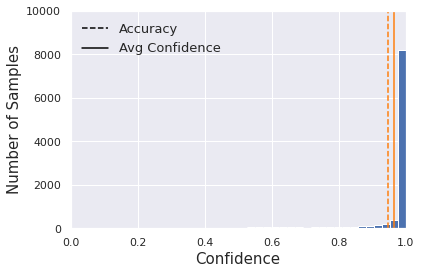

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#local_acc = np.mean(y_local_te_single == targets_te)


print("######## ECE: ##############")
#print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")
#print(f"NonDP accuracy: {nondp_acc}, predicted confidence {np.mean(np.max(y_nondp_te,axis=1))}, ECE {np.abs(nondp_acc - np.mean(np.max(y_nondp_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#1f77b4')
plt.plot(0,0,color='#ff7f0e')
plt.ylim(0,10000)
#plt.plot([0.2338]*20,np.linspace(0,1500,20),linestyle='dashed',color='#1f77b4')
plt.plot([0.9484]*20,np.linspace(0,10000,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
#plt.plot([np.mean(np.max(y_global_te,axis=1))]*20,np.linspace(0,1500,20),color='#1f77b4')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,10000,20),color='#ff7f0e')

#print('non DP accuracy:', np.mean(targets_te==y_noDP_te_single),' confidence:',np.mean(np.max(y_noDP_te,axis=1)),' difference:',np.mean(np.max(y_noDP_te,axis=1))-np.mean(targets_te==y_noDP_te_single))
#print('DP local accuracy:', np.mean(targets_te==y_local_te_single),' confidence:',np.mean(np.max(y_local_te,axis=1)),' difference:',np.mean(np.max(y_local_te,axis=1))-np.mean(targets_te==y_local_te_single))
#print('DP global accuracy:', np.mean(targets_te==y_global_te_single),' confidence:',np.mean(np.max(y_global_te,axis=1)),' difference:',np.mean(np.max(y_global_te,axis=1))-np.mean(targets_te==y_global_te_single))

plt.hist(np.max(y_local_te,axis=1),bins=30)

plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_DPBBP.pdf',format='pdf')
plt.show()



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


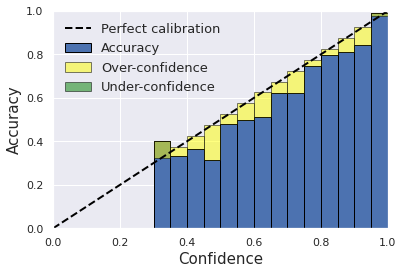

0.15921052631578952

In [ ]:
#%%
store_local = []
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0

#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_MNIST_detail_LOCAL.pdf',format='pdf')
plt.show()
max(xaxis[store_local!=0]-store_local[store_local!=0])


# Training Bayesian Linear 2 Layers MNIST (Gaussian prior) non-DP

In [ ]:
models_dir = 'models_SGLD_MNIST_gaussian'
results_dir = 'results_SGLD_MNIST_gaussian'

mkdir(models_dir)
mkdir(results_dir)

save_dicts = []
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 256
nb_epochs = 15 # We can do less iterations as this method has faster convergence
log_interval = 1

lr = 1e-5
norm_sigma =0.1 
laplace_b=0
noise_multiplier = 1.3
clipping_norm=1.5
DP_or_Not=True
# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

 

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


########################################################################################
net = Net_langevin(lr=lr, cuda=use_cuda, classes=10,DP_or_Not=False, N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=Linear_2L(28*28,10))

## weight saving parameters #######
start_save = 5
save_every = 1 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 90
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
from tqdm import tqdm

for i in range(nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_pred, err = net.fit(x, y)
        #print(cost_pred)
        #print(err)
        err_train[i] += err
        #pred_cost_train[i] += cost_pred
        pred_cost_train[i] += torch.mean(cost_pred)
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    # ---- save weights
    if i >= start_save and i % save_every == 0:
        net.save_sampled_net(max_samples=N_saves)
        save_dicts.append(copy.deepcopy(net.model.state_dict()))
    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')
   
toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)
np.save(results_dir + '/save_dicts.npy',save_dicts )


 


Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engin

  init cost variables:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: This overload of add_ is deprecat

it 0/15, Jtr_pred = 0.567571, err = 0.158783,    time: 8.549930 seconds



    Jdev = 0.422772, err = 0.108200

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 27.77it/s]

it 1/15, Jtr_pred = 0.457773, err = 0.108033,    time: 8.465600 seconds



    Jdev = 0.477143, err = 0.107500

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 27.36it/s]

it 2/15, Jtr_pred = 0.493562, err = 0.109017,    time: 8.592522 seconds



    Jdev = 0.532220, err = 0.114500



100%|██████████| 235/235 [00:08<00:00, 27.83it/s]

it 3/15, Jtr_pred = 0.516935, err = 0.110017,    time: 8.450509 seconds



    Jdev = 0.519353, err = 0.110300



100%|██████████| 235/235 [00:08<00:00, 27.09it/s]

it 4/15, Jtr_pred = 0.519199, err = 0.105783,    time: 8.679873 seconds



    Jdev = 0.539097, err = 0.109200



100%|██████████| 235/235 [00:08<00:00, 26.78it/s]

it 5/15, Jtr_pred = 0.547890, err = 0.108267,    time: 8.780450 seconds

 saving weight samples 1/90


    Jdev = 0.606393, err = 0.116700



100%|██████████| 235/235 [00:08<00:00, 27.99it/s]

it 6/15, Jtr_pred = 0.561729, err = 0.109650,    time: 8.400120 seconds

 saving weight samples 2/90


    Jdev = 0.643397, err = 0.121000



100%|██████████| 235/235 [00:08<00:00, 27.35it/s]

it 7/15, Jtr_pred = 0.556156, err = 0.109300,    time: 8.597215 seconds

 saving weight samples 3/90


    Jdev = 0.566837, err = 0.114200



100%|██████████| 235/235 [00:08<00:00, 27.48it/s]

it 8/15, Jtr_pred = 0.547178, err = 0.107483,    time: 8.559087 seconds

 saving weight samples 4/90


    Jdev = 0.527794, err = 0.103600

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 27.27it/s]

it 9/15, Jtr_pred = 0.555151, err = 0.108567,    time: 8.619252 seconds

 saving weight samples 5/90


    Jdev = 0.613209, err = 0.117700



100%|██████████| 235/235 [00:08<00:00, 27.93it/s]

it 10/15, Jtr_pred = 0.552088, err = 0.108667,    time: 8.420816 seconds

 saving weight samples 6/90


    Jdev = 0.529457, err = 0.107500



100%|██████████| 235/235 [00:08<00:00, 26.57it/s]

it 11/15, Jtr_pred = 0.547161, err = 0.107133,    time: 8.847456 seconds

 saving weight samples 7/90


    Jdev = 0.541717, err = 0.103800



100%|██████████| 235/235 [00:08<00:00, 27.42it/s]

it 12/15, Jtr_pred = 0.543331, err = 0.106200,    time: 8.575445 seconds

 saving weight samples 8/90


    Jdev = 0.556220, err = 0.111900



100%|██████████| 235/235 [00:08<00:00, 28.17it/s]

it 13/15, Jtr_pred = 0.548069, err = 0.109750,    time: 8.349768 seconds

 saving weight samples 9/90


    Jdev = 0.610495, err = 0.117400



100%|██████████| 235/235 [00:08<00:00, 27.64it/s]

it 14/15, Jtr_pred = 0.548381, err = 0.109933,    time: 8.508524 seconds

 saving weight samples 10/90


    Jdev = 0.559244, err = 0.113400

   average time: 9.928762 seconds

Writting models_SGLD_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.422772 (cost_train 0.457773)
  err_dev: 0.103600
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 9.928762s



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


In [ ]:
#model_local.to(device)
#model_local.eval()
from tqdm import tqdm
y_local_te=np.empty((0,10))
targets_te=np.array([])
prob_local=np.array([])
acc = 0 
with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            cost, err, prob = net.eval(data,target)
            acc += err
            y_local_te=np.append(y_local_te,prob.detach().numpy(),axis=0)
            #y_local_te_single=np.append(y_local_te_single,y_local_te[-1].argmax())
            prob_local=np.append(prob,np.array([prob.detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

y_local_te_single= np.argmax(y_local_te,axis=1)
sum(y_local_te_single==targets_te)/10000 - np.mean(np.max(y_local_te,axis=1))

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


-0.07067688938975325

######## ECE: ##############


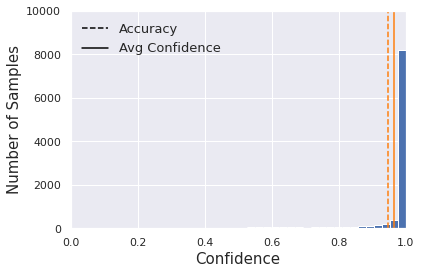

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#local_acc = np.mean(y_local_te_single == targets_te)


print("######## ECE: ##############")
#print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")
#print(f"NonDP accuracy: {nondp_acc}, predicted confidence {np.mean(np.max(y_nondp_te,axis=1))}, ECE {np.abs(nondp_acc - np.mean(np.max(y_nondp_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#1f77b4')
plt.plot(0,0,color='#ff7f0e')
plt.ylim(0,10000)
#plt.plot([0.2338]*20,np.linspace(0,1500,20),linestyle='dashed',color='#1f77b4')
plt.plot([sum(y_local_te_single==targets_te)/10000]*20,np.linspace(0,10000,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
#plt.plot([np.mean(np.max(y_global_te,axis=1))]*20,np.linspace(0,1500,20),color='#1f77b4')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,10000,20),color='#ff7f0e')

#print('non DP accuracy:', np.mean(targets_te==y_noDP_te_single),' confidence:',np.mean(np.max(y_noDP_te,axis=1)),' difference:',np.mean(np.max(y_noDP_te,axis=1))-np.mean(targets_te==y_noDP_te_single))
#print('DP local accuracy:', np.mean(targets_te==y_local_te_single),' confidence:',np.mean(np.max(y_local_te,axis=1)),' difference:',np.mean(np.max(y_local_te,axis=1))-np.mean(targets_te==y_local_te_single))
#print('DP global accuracy:', np.mean(targets_te==y_global_te_single),' confidence:',np.mean(np.max(y_global_te,axis=1)),' difference:',np.mean(np.max(y_global_te,axis=1))-np.mean(targets_te==y_global_te_single))

plt.hist(np.max(y_local_te,axis=1),bins=30)

plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_DPBBP.pdf',format='pdf')
plt.show()



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


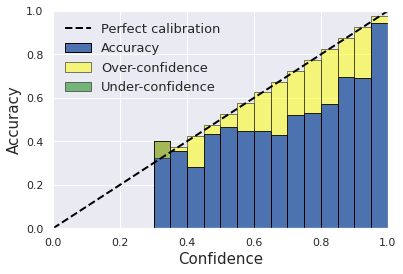

0.25357142857142867

In [ ]:
#%%
store_local = []
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0

#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_MNIST_detail_LOCAL.pdf',format='pdf')
plt.show()
max(xaxis[store_local!=0]-store_local[store_local!=0])


<Figure size 600x400 with 0 Axes>

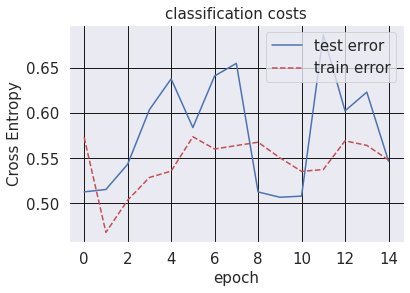

<Figure size 600x400 with 0 Axes>

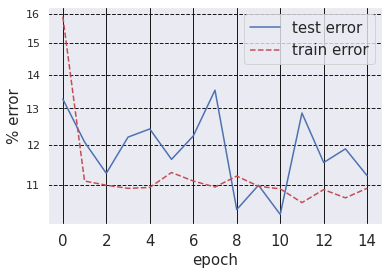

In [ ]:


## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.plot(pred_cost_train, 'r--')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')


# Training for Bayesian CNN training MNIST (Gaussian prior) DP

In [ ]:
models_dir = 'models_SGLD_MNIST_gaussian'
results_dir = 'results_SGLD_MNIST_gaussian'

mkdir(models_dir)
mkdir(results_dir)

save_dicts = []
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 256
nb_epochs = 15 # We can do less iterations as this method has faster convergence
log_interval = 1

lr = 1e-5
norm_sigma =0.1 
laplace_b=0
noise_multiplier = 1.3
clipping_norm=1.5
DP_or_Not=True
# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

 

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


########################################################################################
net = Net_langevin(lr=lr, cuda=use_cuda, classes=10,N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=SampleConvNet_MNIST())

## weight saving parameters #######
start_save = 5
save_every = 1 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 90
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
from tqdm import tqdm

for i in range(nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_pred, err = net.fit(x, y)
        #print(cost_pred)
        #print(err)
        err_train[i] += err
        #pred_cost_train[i] += cost_pred
        pred_cost_train[i] += torch.mean(cost_pred)
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    # ---- save weights
    if i >= start_save and i % save_every == 0:
        net.save_sampled_net(max_samples=N_saves)
        save_dicts.append(copy.deepcopy(net.model.state_dict()))
    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')
   
toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)
np.save(results_dir + '/save_dicts.npy',save_dicts )


 


Data:

Network:

Net:
 Creating Net!! 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


    Total params: 0.03M

Train:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
  0%|          | 0/235 [00:00<?, ?it/s]

  init cost variables:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their ass

it 0/15, Jtr_pred = 0.594567, err = 0.183083,    time: 8.482497 seconds



    Jdev = 0.391650, err = 0.087800

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 28.16it/s]

it 1/15, Jtr_pred = 0.261851, err = 0.066467,    time: 8.349429 seconds



    Jdev = 0.210605, err = 0.054700

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 27.77it/s]

it 2/15, Jtr_pred = 0.237260, err = 0.061050,    time: 8.467314 seconds



    Jdev = 0.215413, err = 0.056200



100%|██████████| 235/235 [00:08<00:00, 27.64it/s]

it 3/15, Jtr_pred = 0.216040, err = 0.056817,    time: 8.508117 seconds



    Jdev = 0.196983, err = 0.048700

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 27.02it/s]

it 4/15, Jtr_pred = 0.203423, err = 0.052850,    time: 8.701454 seconds



    Jdev = 0.236167, err = 0.059900



100%|██████████| 235/235 [00:08<00:00, 27.27it/s]

it 5/15, Jtr_pred = 0.207524, err = 0.054000,    time: 8.625386 seconds

 saving weight samples 1/90


    Jdev = 0.219064, err = 0.056500



100%|██████████| 235/235 [00:08<00:00, 27.47it/s]

it 6/15, Jtr_pred = 0.195699, err = 0.050450,    time: 8.558553 seconds

 saving weight samples 2/90


    Jdev = 0.185892, err = 0.046600

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 27.56it/s]

it 7/15, Jtr_pred = 0.189985, err = 0.048500,    time: 8.531038 seconds

 saving weight samples 3/90


    Jdev = 0.193641, err = 0.052600



100%|██████████| 235/235 [00:08<00:00, 26.97it/s]

it 8/15, Jtr_pred = 0.181305, err = 0.046917,    time: 8.716759 seconds

 saving weight samples 4/90


    Jdev = 0.171101, err = 0.045800

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 27.56it/s]

it 9/15, Jtr_pred = 0.180980, err = 0.047233,    time: 8.528536 seconds

 saving weight samples 5/90


    Jdev = 0.155786, err = 0.042600

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 235/235 [00:08<00:00, 27.71it/s]

it 10/15, Jtr_pred = 0.182929, err = 0.046583,    time: 8.482658 seconds

 saving weight samples 6/90


    Jdev = 0.160553, err = 0.043100



100%|██████████| 235/235 [00:08<00:00, 27.81it/s]

it 11/15, Jtr_pred = 0.177635, err = 0.045667,    time: 8.454824 seconds

 saving weight samples 7/90


    Jdev = 0.181840, err = 0.047000



100%|██████████| 235/235 [00:08<00:00, 28.00it/s]

it 12/15, Jtr_pred = 0.181149, err = 0.046967,    time: 8.404781 seconds

 saving weight samples 8/90


    Jdev = 0.172243, err = 0.045300



100%|██████████| 235/235 [00:08<00:00, 27.69it/s]

it 13/15, Jtr_pred = 0.188860, err = 0.048700,    time: 8.490197 seconds

 saving weight samples 9/90


    Jdev = 0.169348, err = 0.042600



100%|██████████| 235/235 [00:08<00:00, 27.17it/s]


it 14/15, Jtr_pred = 0.173972, err = 0.046467,    time: 8.656815 seconds

 saving weight samples 10/90
    Jdev = 0.250675, err = 0.058500

   average time: 9.821137 seconds

Writting models_SGLD_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.155786 (cost_train 0.173972)
  err_dev: 0.042600
  nb_parameters: 26010 (25.40KB)
  time_per_it: 9.821137s



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


In [ ]:
from tqdm import tqdm
y_local_te=np.empty((0,10))
targets_te=np.array([])
prob_local=np.array([])
acc = 0 
with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            cost, err, prob = net.eval(data,target)
            acc += err
            y_local_te=np.append(y_local_te,prob.detach().numpy(),axis=0)
            #y_local_te_single=np.append(y_local_te_single,y_local_te[-1].argmax())
            prob_local=np.append(prob,np.array([prob.detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

y_local_te_single= np.argmax(y_local_te,axis=1)
sum(y_local_te_single==targets_te)/10000 - np.mean(np.max(y_local_te,axis=1))

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 40/40 [00:01<00:00, 29.80it/s]


-0.02931890131831172

######## ECE: ##############
Local accuracy: 0.9415, predicted confidence 0.9708189013183117, ECE 0.02931890131831172


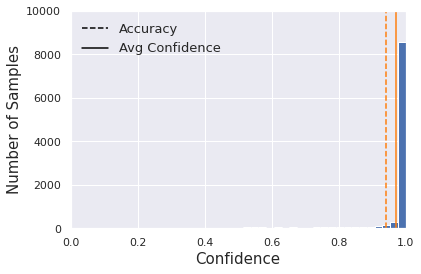

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


local_acc = np.mean(y_local_te_single == targets_te)


print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")
#print(f"NonDP accuracy: {nondp_acc}, predicted confidence {np.mean(np.max(y_nondp_te,axis=1))}, ECE {np.abs(nondp_acc - np.mean(np.max(y_nondp_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#1f77b4')
plt.plot(0,0,color='#ff7f0e')
plt.ylim(0,10000)
#plt.plot([0.2338]*20,np.linspace(0,1500,20),linestyle='dashed',color='#1f77b4')
plt.plot([sum(y_local_te_single==targets_te)/10000]*20,np.linspace(0,10000,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
#plt.plot([np.mean(np.max(y_global_te,axis=1))]*20,np.linspace(0,1500,20),color='#1f77b4')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,10000,20),color='#ff7f0e')

#print('non DP accuracy:', np.mean(targets_te==y_noDP_te_single),' confidence:',np.mean(np.max(y_noDP_te,axis=1)),' difference:',np.mean(np.max(y_noDP_te,axis=1))-np.mean(targets_te==y_noDP_te_single))
#print('DP local accuracy:', np.mean(targets_te==y_local_te_single),' confidence:',np.mean(np.max(y_local_te,axis=1)),' difference:',np.mean(np.max(y_local_te,axis=1))-np.mean(targets_te==y_local_te_single))
#print('DP global accuracy:', np.mean(targets_te==y_global_te_single),' confidence:',np.mean(np.max(y_global_te,axis=1)),' difference:',np.mean(np.max(y_global_te,axis=1))-np.mean(targets_te==y_global_te_single))

plt.hist(np.max(y_local_te,axis=1),bins=30)

plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_DPBBP.pdf',format='pdf')
plt.show()



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


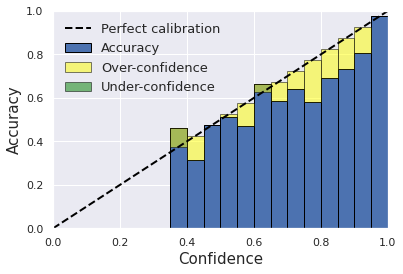

0.19336734693877555

In [ ]:
#%%
store_local = []
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0

#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_MNIST_detail_LOCAL.pdf',format='pdf')
plt.show()
print("######## MCE: ##############")
max(xaxis[store_local!=0]-store_local[store_local!=0])
